In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../input/train-folds1/train_folds1.csv")
df_test = pd.read_csv("../input/song-popularity-prediction/test.csv")
sample_submission = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")

In [3]:
df.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,kfold
0,26884,176594.0,0.642499,0.698547,0.831382,-0.000612,0.0,0.525090,-10.804419,1,0.065138,100.669672,4,0.905913,0,0
1,3560,214896.0,0.116824,NaN,NaN,0.001415,0.0,0.109957,-8.412888,1,0.043684,99.995444,4,0.315906,1,0
2,19597,182017.0,0.425886,0.638298,0.556077,0.000442,5.0,0.130885,-7.432726,0,0.329377,133.138531,3,0.959305,1,0
3,32839,245249.0,NaN,0.552552,0.483716,0.001391,10.0,0.106088,-10.526611,0,0.041864,125.622082,3,0.613241,0,0
4,36703,143096.0,0.189742,0.673393,0.905942,0.003532,NaN,0.070967,-5.855506,0,0.139055,113.444411,4,0.720383,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
 15  kfold             40000 non-null  int64  
dtypes: float64(11), int64(5)
memory usage: 4

In [5]:
df.isnull().sum()

id                     0
song_duration_ms    4101
acousticness        3992
danceability        4026
energy              3975
instrumentalness    3985
key                 4065
liveness            4086
loudness            3957
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
kfold                  0
dtype: int64

In [6]:
df.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,kfold
count,40000.00000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400,2.000000
std,11547.14972,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268,1.414231
min,0.00000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000,0.000000
25%,9999.75000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000,1.000000
50%,19999.50000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000,2.000000
75%,29999.25000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000,3.000000
max,39999.00000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000,4.000000


<AxesSubplot:xlabel='song_popularity', ylabel='count'>

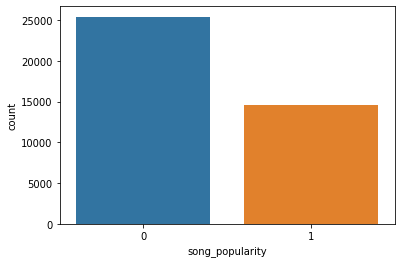

In [7]:
sns.countplot(df.song_popularity)

In [8]:
df.columns

Index(['id', 'song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
       'speechiness', 'tempo', 'time_signature', 'audio_valence',
       'song_popularity', 'kfold'],
      dtype='object')

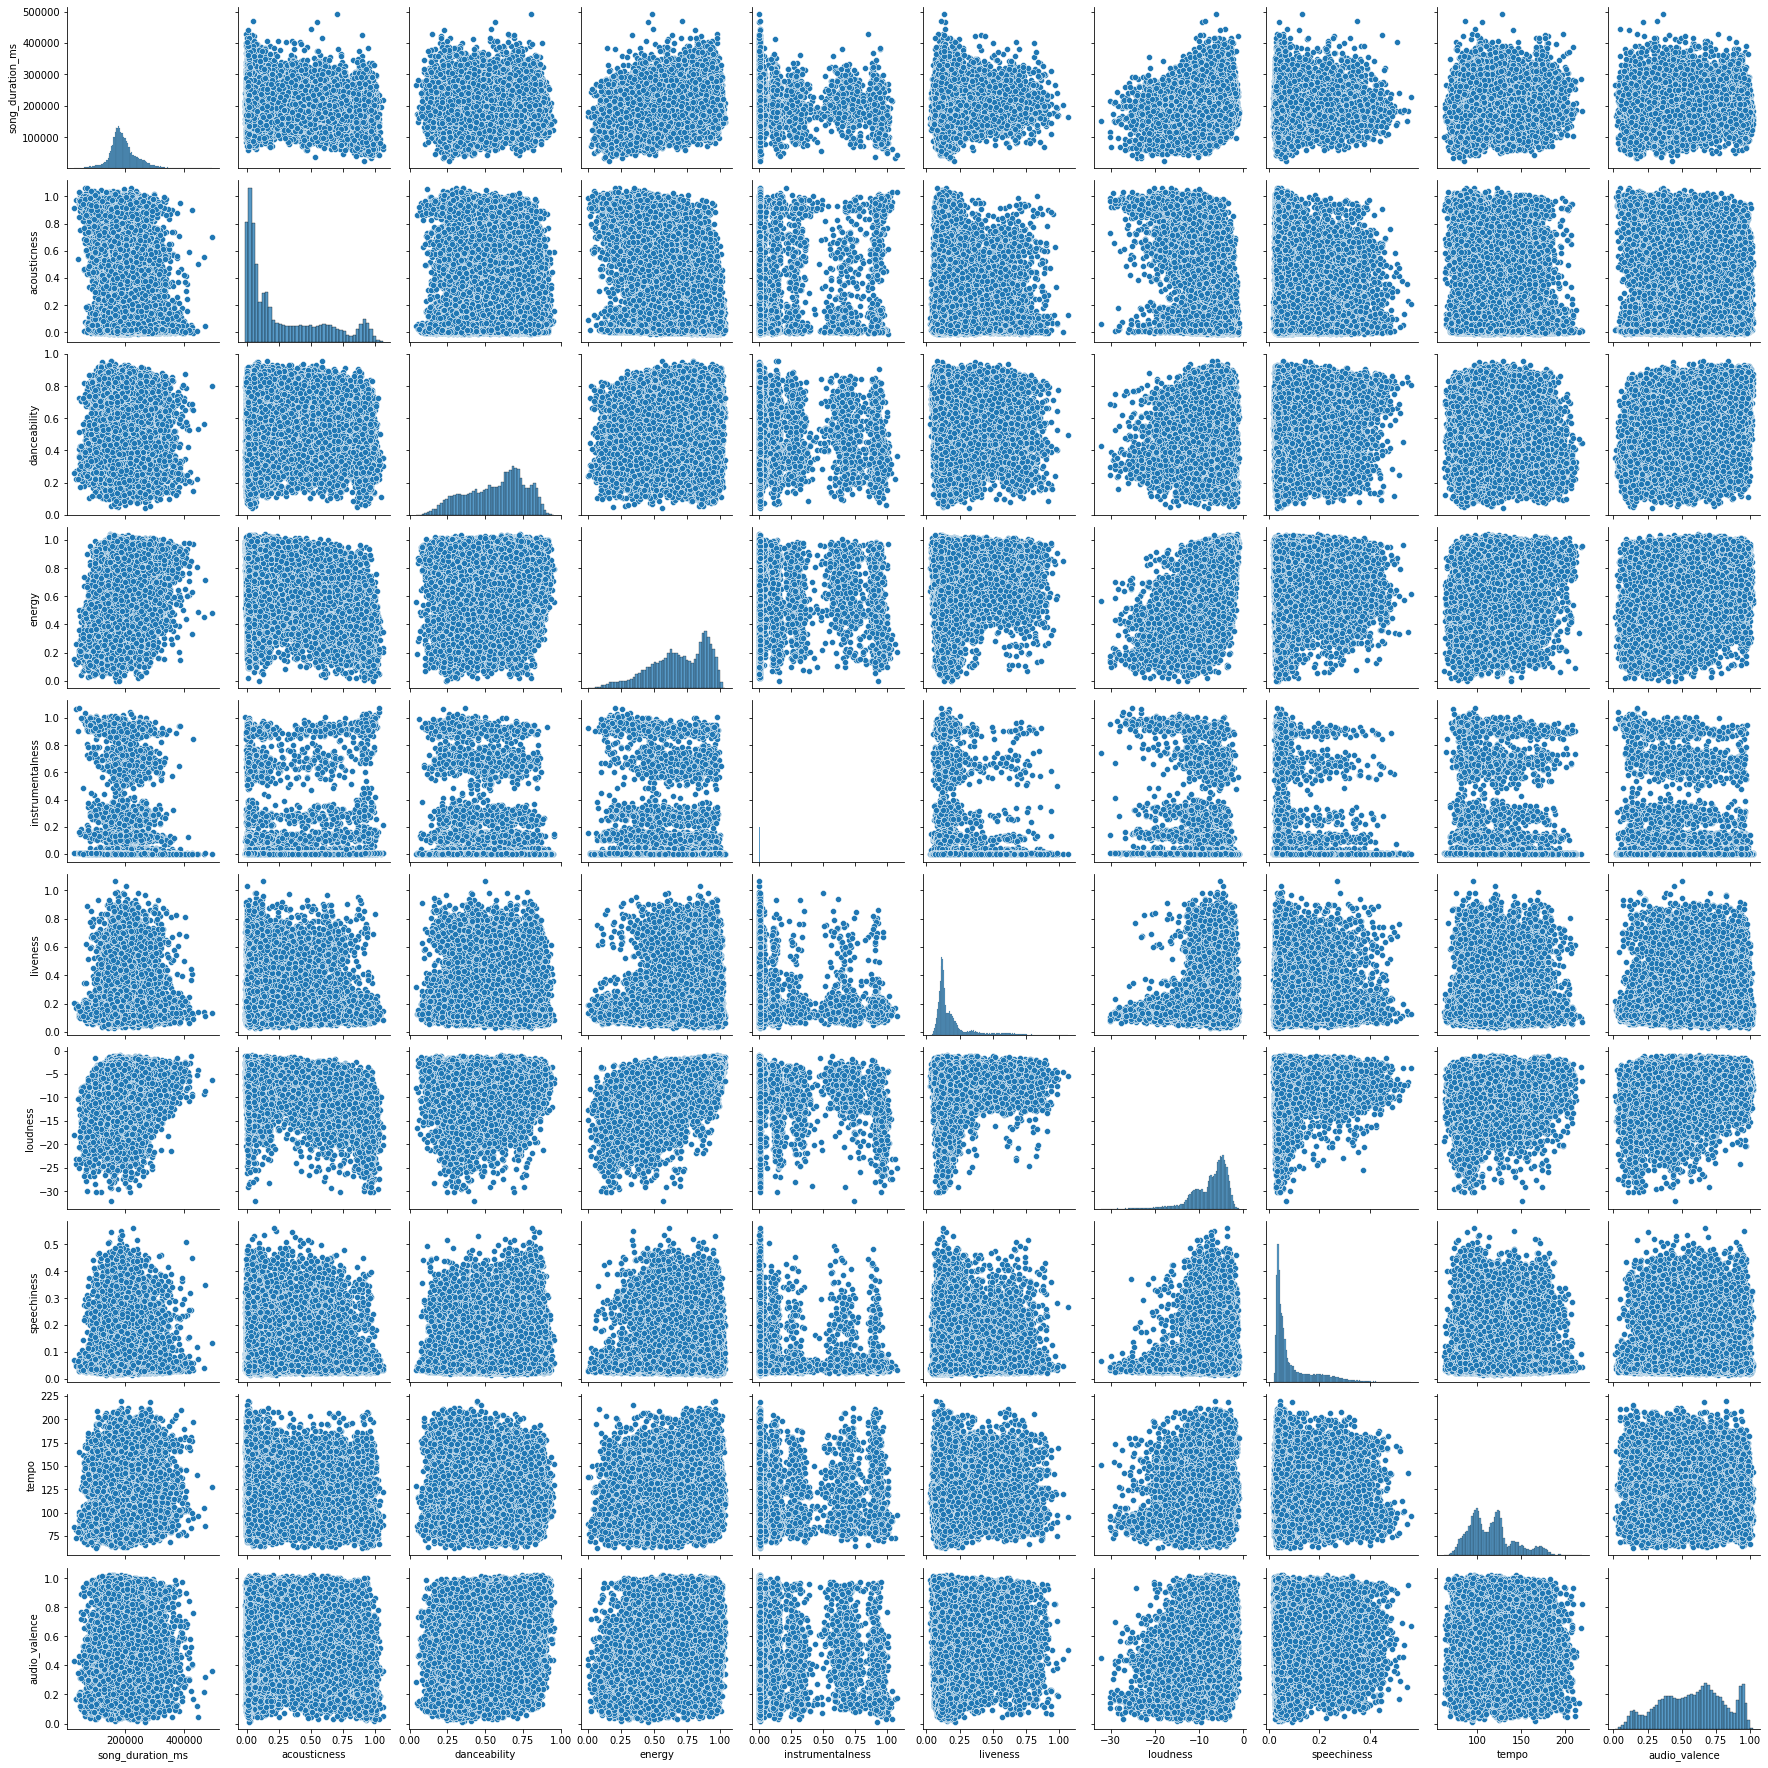

In [9]:
columns_for_scatter = ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 
                       'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']

sns.pairplot(df[columns_for_scatter])

In [10]:
"""useful_features = [columns for columns in df.columns if columns not in ("id", "song_popularity", "kfold")]
df_test = df_test[useful_features]
columns_to_impute = [col for col in useful_features if df[col].isnull().sum() > 0]"""

'useful_features = [columns for columns in df.columns if columns not in ("id", "song_popularity", "kfold")]\ndf_test = df_test[useful_features]\ncolumns_to_impute = [col for col in useful_features if df[col].isnull().sum() > 0]'

In [11]:
useful_features = [columns for columns in df.columns if columns not in ("id", "song_popularity", "kfold")]
df_test = df_test[useful_features]
columns_to_impute = [col for col in useful_features if df[col].isnull().sum() > 0]

final_test_predictions = []
final_valid_predictions = {}
for fold in range(5):
    X_train = df[df.kfold != fold].reset_index(drop=True)
    X_valid = df[df.kfold == fold].reset_index(drop=True)
    X_test = df_test.copy()
    
    valid_ids = X_valid.id.values.tolist()
    
    y_train = X_train["song_popularity"]
    y_valid = X_valid["song_popularity"]
    
    X_train = X_train[useful_features]
    X_valid = X_valid[useful_features]
    
    imputer = SimpleImputer(strategy="mean")
    X_train[columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])
    X_valid[columns_to_impute] = imputer.transform(X_valid[columns_to_impute])
    X_test[columns_to_impute] = imputer.transform(X_test[columns_to_impute])
    
    scaler = preprocessing.RobustScaler()
    X_train[useful_features] = scaler.fit_transform(X_train[useful_features])
    X_valid[useful_features] = scaler.transform(X_valid[useful_features])
    X_test[useful_features] = scaler.transform(X_test[useful_features])
    
    ros = RandomOverSampler(random_state=fold)
    X_oversample, y_oversample = ros.fit_resample(X_train, y_train)
    
    model = CatBoostClassifier(random_state=fold, 
                               silent=True, 
                               learning_rate=0.05, 
                               max_depth=9, task_type="GPU", 
                               iterations=500, eval_metric="AUC", 
                               loss_function='Logloss')
    
    model.fit(X_oversample, y_oversample)
    preds_valid = model.predict(X_valid)
    test_preds = model.predict(X_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
     
    print("accuracy is:",accuracy_score(y_valid, preds_valid))
    print(classification_report(y_valid, preds_valid))

final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1"]
final_valid_predictions.to_csv("train_pred_1.csv", index=False)

sample_submission.target = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_1"]
sample_submission.to_csv("test_pred_1.csv", index=False)

accuracy is: 0.555
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      5085
           1       0.41      0.50      0.45      2915

    accuracy                           0.56      8000
   macro avg       0.54      0.54      0.54      8000
weighted avg       0.58      0.56      0.56      8000

accuracy is: 0.561375
              precision    recall  f1-score   support

           0       0.67      0.60      0.64      5085
           1       0.41      0.49      0.45      2915

    accuracy                           0.56      8000
   macro avg       0.54      0.55      0.54      8000
weighted avg       0.58      0.56      0.57      8000

accuracy is: 0.55625
              precision    recall  f1-score   support

           0       0.67      0.58      0.63      5085
           1       0.41      0.51      0.46      2915

    accuracy                           0.56      8000
   macro avg       0.54      0.55      0.54      8000
weighted avg

In [12]:
df = pd.read_csv("../input/train-folds1/train_folds1.csv")
df_test = pd.read_csv("../input/song-popularity-prediction/test.csv")
sample_submission = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")

useful_features = [columns for columns in df.columns if columns not in ("id", "song_popularity", "kfold")]
df_test = df_test[useful_features]
columns_to_impute = [col for col in useful_features if df[col].isnull().sum() > 0]

final_test_predictions = []
final_valid_predictions = {}
for fold in range(5):
    X_train = df[df.kfold != fold].reset_index(drop=True)
    X_valid = df[df.kfold == fold].reset_index(drop=True)
    X_test = df_test.copy()
    
    valid_ids = X_valid.id.values.tolist()
    
    y_train = X_train["song_popularity"]
    y_valid = X_valid["song_popularity"]
    
    X_train = X_train[useful_features]
    X_valid = X_valid[useful_features]
    
    imputer = SimpleImputer(strategy="mean")
    X_train[columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])
    X_valid[columns_to_impute] = imputer.transform(X_valid[columns_to_impute])
    X_test[columns_to_impute] = imputer.transform(X_test[columns_to_impute])
    
    scaler = preprocessing.RobustScaler()
    X_train[useful_features] = scaler.fit_transform(X_train[useful_features])
    X_valid[useful_features] = scaler.transform(X_valid[useful_features])
    X_test[useful_features] = scaler.transform(X_test[useful_features])
    
    ros = RandomOverSampler(random_state=fold)
    X_oversample, y_oversample = ros.fit_resample(X_train, y_train)
    
    model = xgb.XGBClassifier(random_state=fold,
                              tree_method='gpu_hist',
                              gpu_id=0,
                              predictor="gpu_predictor",
                              n_estimators=500,
                              learning_rate=0.05,
                              verbosity=1,
                              eval_metric="logloss")
       
    
    model.fit(X_oversample, y_oversample)
    preds_valid = model.predict(X_valid)
    test_preds = model.predict(X_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
     
    print("accuracy is:",accuracy_score(y_valid, preds_valid))
    print(classification_report(y_valid, preds_valid))

final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_2"]
final_valid_predictions.to_csv("train_pred_2.csv", index=False)

sample_submission.target = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_2"]
sample_submission.to_csv("test_pred_2.csv", index=False)

accuracy is: 0.55775
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      5085
           1       0.40      0.45      0.43      2915

    accuracy                           0.56      8000
   macro avg       0.53      0.54      0.53      8000
weighted avg       0.57      0.56      0.56      8000

accuracy is: 0.561375
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      5085
           1       0.40      0.43      0.42      2915

    accuracy                           0.56      8000
   macro avg       0.53      0.53      0.53      8000
weighted avg       0.57      0.56      0.56      8000

accuracy is: 0.56225
              precision    recall  f1-score   support

           0       0.67      0.63      0.64      5085
           1       0.41      0.45      0.43      2915

    accuracy                           0.56      8000
   macro avg       0.54      0.54      0.54      8000
weighted a

In [13]:
df = pd.read_csv("../input/train-folds1/train_folds1.csv")
df_test = pd.read_csv("../input/song-popularity-prediction/test.csv")
sample_submission = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")

useful_features = [columns for columns in df.columns if columns not in ("id", "song_popularity", "kfold")]
df_test = df_test[useful_features]
columns_to_impute = [col for col in useful_features if df[col].isnull().sum() > 0]

final_test_predictions = []
final_valid_predictions = {}
for fold in range(5):
    X_train = df[df.kfold != fold].reset_index(drop=True)
    X_valid = df[df.kfold == fold].reset_index(drop=True)
    X_test = df_test.copy()
    
    valid_ids = X_valid.id.values.tolist()
    
    y_train = X_train["song_popularity"]
    y_valid = X_valid["song_popularity"]
    
    X_train = X_train[useful_features]
    X_valid = X_valid[useful_features]
    
    imputer = SimpleImputer(strategy="mean")
    X_train[columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])
    X_valid[columns_to_impute] = imputer.transform(X_valid[columns_to_impute])
    X_test[columns_to_impute] = imputer.transform(X_test[columns_to_impute])
    
    scaler = preprocessing.RobustScaler()
    X_train[useful_features] = scaler.fit_transform(X_train[useful_features])
    X_valid[useful_features] = scaler.transform(X_valid[useful_features])
    X_test[useful_features] = scaler.transform(X_test[useful_features])
    
    ros = RandomOverSampler(random_state=fold)
    X_oversample, y_oversample = ros.fit_resample(X_train, y_train)
    
    
    model = RandomForestClassifier(random_state=fold, 
                                   n_estimators=500, 
                                   max_depth=17, 
                                   min_samples_leaf=2,
                                   min_samples_split=5,
                                   criterion="entropy")
    
    
    model.fit(X_oversample, y_oversample)
    preds_valid = model.predict(X_valid)
    test_preds = model.predict(X_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
     
    print("accuracy is:",accuracy_score(y_valid, preds_valid))
    print(classification_report(y_valid, preds_valid))

final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_3"]
final_valid_predictions.to_csv("train_pred_3.csv", index=False)

sample_submission.target = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_3"]
sample_submission.to_csv("test_pred_3.csv", index=False)

accuracy is: 0.57875
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      5085
           1       0.41      0.38      0.40      2915

    accuracy                           0.58      8000
   macro avg       0.54      0.54      0.54      8000
weighted avg       0.57      0.58      0.57      8000

accuracy is: 0.590375
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      5085
           1       0.43      0.36      0.39      2915

    accuracy                           0.59      8000
   macro avg       0.54      0.54      0.54      8000
weighted avg       0.58      0.59      0.58      8000

accuracy is: 0.58475
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      5085
           1       0.42      0.38      0.40      2915

    accuracy                           0.58      8000
   macro avg       0.54      0.54      0.54      8000
weighted a

In [14]:
df = pd.read_csv("../input/train-folds1/train_folds1.csv")
df_test = pd.read_csv("../input/song-popularity-prediction/test.csv")
sample_submission = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")

df1 = pd.read_csv("train_pred_1.csv")
df2 = pd.read_csv("train_pred_2.csv")
df3 = pd.read_csv("train_pred_3.csv")

df_test1 = pd.read_csv("test_pred_1.csv")
df_test2 = pd.read_csv("test_pred_2.csv")
df_test3 = pd.read_csv("test_pred_3.csv")

df = df.merge(df1, on="id", how="left")
df = df.merge(df2, on="id", how="left")
df = df.merge(df3, on="id", how="left")

df_test = df_test.merge(df_test1, on="id", how="left")
df_test = df_test.merge(df_test2, on="id", how="left")
df_test = df_test.merge(df_test3, on="id", how="left")

df.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,kfold,pred_1,pred_2,pred_3
0,26884,176594.0,0.642499,0.698547,0.831382,-0.000612,0.0,0.525090,-10.804419,1,0.065138,100.669672,4,0.905913,0,0,0,0,0
1,3560,214896.0,0.116824,NaN,NaN,0.001415,0.0,0.109957,-8.412888,1,0.043684,99.995444,4,0.315906,1,0,1,1,1
2,19597,182017.0,0.425886,0.638298,0.556077,0.000442,5.0,0.130885,-7.432726,0,0.329377,133.138531,3,0.959305,1,0,0,0,1
3,32839,245249.0,NaN,0.552552,0.483716,0.001391,10.0,0.106088,-10.526611,0,0.041864,125.622082,3,0.613241,0,0,0,1,0
4,36703,143096.0,0.189742,0.673393,0.905942,0.003532,NaN,0.070967,-5.855506,0,0.139055,113.444411,4,0.720383,1,0,0,0,0


In [15]:
useful_features = ["pred_1", "pred_2", "pred_3"]
df_test = df_test[useful_features]

from imblearn.over_sampling import SMOTE

final_predictions = []
for fold in range(5):
    X_train =  df[df.kfold != fold].reset_index(drop=True)
    X_valid = df[df.kfold == fold].reset_index(drop=True)
    X_test = df_test.copy()

    y_train = X_train["song_popularity"]
    y_valid = X_valid["song_popularity"]
    
    X_train = X_train[useful_features]
    X_valid = X_valid[useful_features]
    
    smote = SMOTE(random_state=fold)
    X_oversample, y_oversample = smote.fit_resample(X_train, y_train)
    
    model = CatBoostClassifier( random_state=fold,                               
                                task_type="GPU", 
                                eval_metric="AUC",
                                verbose=1000)
    
    model.fit(X_oversample, y_oversample)
    
    preds_valid = model.predict(X_valid)
    test_preds = model.predict(X_test)
    final_predictions.append(test_preds)
    print("accuracy is:",accuracy_score(y_valid, preds_valid))
    print(classification_report(y_valid, preds_valid))

Learning rate set to 0.027495
0:	learn: 0.5476916	total: 23.4ms	remaining: 23.3s
999:	learn: 0.5589246	total: 24.1s	remaining: 0us
accuracy is: 0.544875
              precision    recall  f1-score   support

           0       0.68      0.55      0.60      5085
           1       0.41      0.54      0.46      2915

    accuracy                           0.54      8000
   macro avg       0.54      0.54      0.53      8000
weighted avg       0.58      0.54      0.55      8000

Learning rate set to 0.027495
0:	learn: 0.5552427	total: 24ms	remaining: 24s
999:	learn: 0.5587457	total: 22.6s	remaining: 0us
accuracy is: 0.55575
              precision    recall  f1-score   support

           0       0.68      0.57      0.62      5085
           1       0.41      0.52      0.46      2915

    accuracy                           0.56      8000
   macro avg       0.55      0.55      0.54      8000
weighted avg       0.58      0.56      0.56      8000

Learning rate set to 0.027495
0:	learn: 0.559

In [16]:
threshold = 0.52
predictions = (model.predict_proba(X_valid)[:, 1] >= threshold).astype(int)

print('Valuation for test data only:')
print(classification_report(y_valid, preds_valid))
print("----------------------------------------------------------------------")
print('Valuation for test data only  (new_threshold):')
print(classification_report(y_valid, predictions))

Valuation for test data only:
              precision    recall  f1-score   support

           0       0.68      0.58      0.62      5084
           1       0.42      0.53      0.46      2916

    accuracy                           0.56      8000
   macro avg       0.55      0.55      0.54      8000
weighted avg       0.58      0.56      0.57      8000

----------------------------------------------------------------------
Valuation for test data only  (new_threshold):
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      5084
           1       0.43      0.43      0.43      2916

    accuracy                           0.58      8000
   macro avg       0.55      0.55      0.55      8000
weighted avg       0.58      0.58      0.58      8000



In [17]:
f_list = []
predictions_test = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
f_list.append(predictions_test)
preds = np.column_stack(f_list)

In [18]:
sample_submission["song_popularity"] = preds
sample_submission.to_csv("submission.csv", index=False)